# process spectra for AuxTel with new spectractor (version=2.5, July 2023, branch  run auxtel september 2023)

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : September 6th th 2023
- update : 2023-09-14 

- version v7 : Work with extr

This notebook is to help for finding the position of order 0



# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2023_35/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_35/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2023_35/Spectractor 	setup


In [3]:
import sys
print(sys.path)

['/sdf/data/rubin/user/dagoret/AuxTel_summit_tests_2023/runspectractor_standalone/2023_09', '/home/d/dagoret/repos/repos_w_2023_35/analysis_tools/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/cp_pipe/g857a3418e4+7df23b908a/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/shapelet/g44018dc512+ea6441928c/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/meas_modelfit/g93c4d6e787+79b822255a/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/scarlet_extensions/g9d18589735+d445b4966c/lib/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/proxmin/g33b4157f25/lib/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/scarlet/g63ff1f842d+4083830bf8/lib/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/meas_extensions_scarlet/g943cb464a2+f79590064d/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-

In [4]:
all_paths_to_remove = ['/opt/conda/lib/python3.10/site-packages','/pbs/home/d/dagoret/.local/lib/python3.10/site-packages']

for path_to_remove in all_paths_to_remove:
    if path_to_remove in sys.path:
        print(f"remove {path_to_remove} from sys.path")
        sys.path.remove(path_to_remove)

In [5]:
sys.path

['/sdf/data/rubin/user/dagoret/AuxTel_summit_tests_2023/runspectractor_standalone/2023_09',
 '/home/d/dagoret/repos/repos_w_2023_35/analysis_tools/python',
 '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/cp_pipe/g857a3418e4+7df23b908a/python',
 '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/shapelet/g44018dc512+ea6441928c/python',
 '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/meas_modelfit/g93c4d6e787+79b822255a/python',
 '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/scarlet_extensions/g9d18589735+d445b4966c/lib/python',
 '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/proxmin/g33b4157f25/lib/python',
 '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/scarlet/g63ff1f842d+4083830bf8/lib/python',
 '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/meas_extensions_scarlet/g943cb464a2+f79590064d/python',
 '/opt/lsst/software/stack/stack/miniconda3-py

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [7]:
print(sys.executable)
print(sys.version)
print(sys.version_info)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/bin/python3
3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:17) [GCC 12.2.0]
sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)


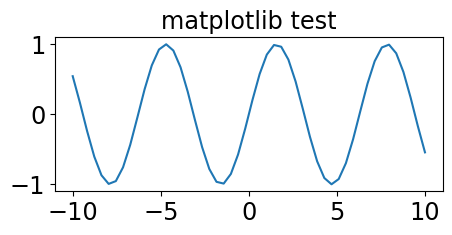

In [8]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.title("matplotlib test")
plt.show()


In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.22.0'

In [11]:
import scipy
print(scipy.__version__)

1.10.1


In [12]:
from astropy.io import fits
from astropy.coordinates import Angle
from astropy import units as u
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters
#dumpfitparameters
from spectractor.extractor.images import *
from spectractor.config import load_config, set_logger
from scipy import ndimage, misc

In [13]:
import logging

In [14]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [15]:
from distutils.dir_util import copy_tree
import shutil

In [16]:
from astroquery.simbad import Simbad
import astroquery
astroquery.__version__
result_table = Simbad.query_object("M1")

In [17]:
def find_target_name(tag):
    try:
        target_name=tag
        result_table = Simbad.query_object(target_name)
        return target_name
    except:
        target_name_stripped = ''.join(tag.split())
        result_table = Simbad.query_object(target_name_stripped)
        return target_name_stripped 
           

# Configuration

## Logger

In [18]:
my_logger = logging

## Config for the notebook

In [19]:
version="v7.0"  # version for taking images from data/2023 (images come from usdf)
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True
FLAG_RUNWITHEXCEPTIONS = False

## Configuration for Spectractor

In [20]:
print("List of configuration files available : ",os.listdir("config"))

List of configuration files available :  ['auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_findrot_Sept2023.ini', 'auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini', 'auxtel_config_holo_DECONVOLUTION_FFMv_REBIN1_Janv2023.ini', '.ipynb_checkpoints']


### config files
- auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_findrot_Sept2023.ini with holo4_001 because rotation of angle with hessian

- auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini or 
  auxtel_config_holo_DECONVOLUTION_FFMv_REBIN1_Janv2023.ini, with holo4_003 becaus no rotation angle is required

In [21]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini' ,
                                'auxtel_config_holo_DECONVOLUTION_FFMv_REBIN1_Janv2023.ini',
                                'auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_findrot_Sept2023.ini']
# because holo4_001 is slightly rotated compared to holo4_003, we need to activate in Spectractor the search of the rotation angle by hessian method
config_idx = len(list_of_spectractorconfigfiles)-3
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [22]:
configfilename

'./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_findrot_Sept2023.ini'

In [23]:
configdir

'config_DECONVOLUTION_FFMv_REBIN2_findrot_Sept2023'

In [24]:
! pwd

/sdf/data/rubin/user/dagoret/AuxTel_summit_tests_2023/runspectractor_standalone/2023_09


In [25]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_findrot_Sept2023.ini


In [26]:
load_config(configfilename)

In [27]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 2048
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.1904
CCD_PIXEL2MM 0.02
CCD_REBIN 2
CONFIG_DIR ../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR extractor/dispersers/
DISPLAY False
DISTANCE2CCD 181
DISTANCE2CCD_ERR 0.4
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
LAMBDAS [ 300  301  302  303  304  305  306  307  308  309  310  311  312  313
  314  315  316  317  318  319  320  321  322  323  324  325  326  327
  328  329  330  331  332  333  334  335  336  337  338  339  340  341
  342  343  344  345  346  347  348  349  350  351  352  353  354  355
  356  357  358  359  360  361  362  363  364  365  366  367  368  369
  370  371  372  373  374  375  376  377  378  379  380  381  382  383
  384  385  386  387  388  389  390  391  392  393  394  395  396  397
  3

In [28]:
dir(parameters)

['ASTROMETRYNET_DIR',
 'BGD_ORDER',
 'CALIB_BGD_NPARAMS',
 'CALIB_BGD_ORDER',
 'CALIB_BGD_WIDTH',
 'CALIB_PEAK_WIDTH',
 'CALIB_SAVGOL_ORDER',
 'CALIB_SAVGOL_WINDOW',
 'CCD_ARCSEC2RADIANS',
 'CCD_GAIN',
 'CCD_IMSIZE',
 'CCD_MAXADU',
 'CCD_PIXEL2ARCSEC',
 'CCD_PIXEL2MM',
 'CCD_REBIN',
 'CONFIG_DIR',
 'DEBUG',
 'DEBUG_LOGGING',
 'DISPERSER_DIR',
 'DISPLAY',
 'DISTANCE2CCD',
 'DISTANCE2CCD_ERR',
 'FLAM_TO_ADURATE',
 'GRATING_ORDER_2OVER1',
 'LAMBDAS',
 'LAMBDA_MAX',
 'LAMBDA_MIN',
 'LAMBDA_STEP',
 'LIBRADTRAN_DIR',
 'LINEWIDTH',
 'OBS_ALTITUDE',
 'OBS_CAMERA_DEC_FLIP_SIGN',
 'OBS_CAMERA_RA_FLIP_SIGN',
 'OBS_CAMERA_ROTATION',
 'OBS_DIAMETER',
 'OBS_EPOCH',
 'OBS_FULL_INSTRUMENT_TRANSMISSON',
 'OBS_LATITUDE',
 'OBS_NAME',
 'OBS_OBJECT_TYPE',
 'OBS_QUANTUM_EFFICIENCY',
 'OBS_SECONDARY_DIAMETER',
 'OBS_SURFACE',
 'OBS_TELESCOPE_TRANSMISSION',
 'OBS_TRANSMISSION_SYSTEMATICS',
 'PAPER',
 'PIXDIST_BACKGROUND',
 'PIXSHIFT_PRIOR',
 'PIXWIDTH_BACKGROUND',
 'PIXWIDTH_BOXSIZE',
 'PIXWIDTH_SIGNAL',
 'P

# Exposure config

In [29]:
! ls logbooks

auxtellogbook_collimator~holo4_003_20230912_v7.0.csv
auxtellogbook_cyl_lens~holo4_001_20230912_v7.0.csv
auxtellogbook_cyl_lens~holo4_003_20230912_v7.0.csv
auxtellogbook_empty~holo4_001_20230912_v7.0.csv
auxtellogbook_empty~holo4_003_20230815_v7.0.csv
auxtellogbook_empty~holo4_003_20230817_v7.0.csv
auxtellogbook_empty~holo4_003_20230912_v7.0.csv


In [30]:
# path index for each month

DATE = '20230913'
all_filterdispersernames = ["empty~holo4_001",\
                        "empty~holo4_003",\
                        "collimator~holo4_003",\
                        "cyl_lens~holo4_001",\
                        "cyl_lens~holo4_003",\
                       ]
filterdispersername = all_filterdispersernames[2]


imagemode = "postISRCCD"
#imagemode = "unflattened"

In [31]:
disperser_label = filterdispersername.split("~")[-1]

## Paths

In [32]:
# select if we run at CC or not (locally) 
# /sps/lsst/groups/auxtel/data/2022/holo/20220317
HOSTCC=False
LAPTOP=True

In [33]:
def GetPaths(computer_name):
    """
    """
    
    if computer_name == "HOSTCC":
        
        path_auxtel="/sps/lsst/groups/auxtel"
        path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
    
        path_images=os.path.join(path_auxtel,"data/hack_usdf/my_postisrccd_img_forspectractor_2023/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)
        
    elif computer_name == "LAPTOP1":
        path_auxtel="/Users/dagoret/DATA/AuxTelData2023"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2023/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)
        
        
    elif computer_name == "WORKIMAC":
        path_auxtel="/Users/sylvie/DATA/AuxTelData2023"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2023/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)
            
            
        
    elif computer_name == "HOMEIMAC":
        path_auxtel="/Volumes/Backup2020/DATA"
        path_spectractor=os.path.join(path_auxtel,"MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(".","config")
        path_images=os.path.join(path_auxtel,"hack_usdf/my_postisrccd_img_forspectractor_2023/"+filterdispersername+"/"+DATE)
        
        # /Volumes/Backup2020/DATA/AuxTelDATA2023/data/2023/OutputSpectractor
        
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode)
            
    elif computer_name == "USDF":
        path_auxtel="/home/d/dagoret/rubin-user/DATA"
        path_spectractor=os.path.join("/home/d/dagoret","repos/repos_w_2023_35/Spectractor")
        path_spectractor_config=os.path.join(".","config")
        path_images=os.path.join(path_auxtel,"AuxtelData2023/my_postisrccd_img_forspectractor_2023/"+filterdispersername+"/"+DATE)
        
        # /Volumes/Backup2020/DATA/AuxTelDATA2023/data/2023/OutputSpectractor
        
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"AuxtelData2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"AuxtelData2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"AuxtelData2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"AuxtelData2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"AuxtelData2023/OutputSpectractor/"+imagemode)     
        
    else:
        print(f"Unknown computer {computer_name}")
        
              
    return path_auxtel,path_spectractor,path_spectractor_config,path_images,path_toptoptopoutput_spectractor, path_toptopoutput_spectractor, path_topoutput_spectractor, path_output_spectractor
        

In [34]:
mycomputer_name = "USDF"
path_auxtel,path_spectractor,path_spectractor_config,path_images,path_toptoptopoutput_spectractor, path_toptopoutput_spectractor, path_topoutput_spectractor, path_output_spectractor  = GetPaths(mycomputer_name)

In [35]:
path_images

'/home/d/dagoret/rubin-user/DATA/AuxtelData2023/my_postisrccd_img_forspectractor_2023/empty~holo4_001/20230912'

In [36]:
path_topoutput_spectractor

'/home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_001/config_DECONVOLUTION_FFMv_REBIN2_findrot_Sept2023'

In [37]:
path_output_spectractor

'/home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_001/config_DECONVOLUTION_FFMv_REBIN2_findrot_Sept2023/20230912'

# Utility Functions

In [38]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [39]:
!ls logbooks

auxtellogbook_collimator~holo4_003_20230912_v7.0.csv
auxtellogbook_cyl_lens~holo4_001_20230912_v7.0.csv
auxtellogbook_cyl_lens~holo4_003_20230912_v7.0.csv
auxtellogbook_empty~holo4_001_20230912_v7.0.csv
auxtellogbook_empty~holo4_003_20230815_v7.0.csv
auxtellogbook_empty~holo4_003_20230817_v7.0.csv
auxtellogbook_empty~holo4_003_20230912_v7.0.csv


In [40]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [41]:
filename_logbook

'logbooks/auxtellogbook_empty~holo4_001_20230912_v7.0.csv'

In [42]:
df=pd.read_csv(filename_logbook,index_col=0)

In [43]:
pd.set_option('display.max_rows', None)

In [44]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2023-09-13T00:40:46.134,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023091200152_pseudo-postisrccd.fits,152,HD312412,empty_1,holo4_001,1.080808,60.0,...,-0.1750,37.525002,5.6712,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2023-09-13T00:41:59.155,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023091200153_pseudo-postisrccd.fits,153,HD312412,empty_1,holo4_001,1.082666,90.0,...,-0.1500,38.025002,5.4210,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2023-09-13T01:51:16.939,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023091200212_pseudo-postisrccd.fits,212,zet Sgr,empty_1,holo4_001,1.061014,30.0,...,-0.4125,59.349998,4.5870,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2023-09-13T01:51:59.913,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023091200213_pseudo-postisrccd.fits,213,zet Sgr,empty_1,holo4_001,1.062033,60.0,...,-0.4000,59.575001,5.0040,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2023-09-13T01:53:12.923,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023091200214_pseudo-postisrccd.fits,214,zet Sgr,empty_1,holo4_001,1.063787,90.0,...,-0.5000,60.275002,5.0874,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2023-09-13T01:58:40.456,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023091200215_pseudo-postisrccd.fits,215,HD167611,empty_1,holo4_001,1.213810,30.0,...,-0.5000,59.325001,5.4210,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2023-09-13T01:59:23.484,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023091200216_pseudo-postisrccd.fits,216,HD167611,empty_1,holo4_001,1.216035,60.0,...,-0.4750,58.924999,6.0882,NaN,NaN,NaN,NaN,,NaN,NaN
7,7,2023-09-13T02:00:36.476,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023091200217_pseudo-postisrccd.fits,217,HD167611,empty_1,holo4_001,1.219841,90.0,...,-0.5500,60.862499,5.3376,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2023-09-13T02:23:08.824,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023091200228_pseudo-postisrccd.fits,228,M18,empty_1,holo4_001,1.300291,30.0,...,-0.7500,65.500000,4.0866,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2023-09-13T02:23:51.751,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023091200229_pseudo-postisrccd.fits,229,M18,empty_1,holo4_001,1.303172,60.0,...,-0.7500,65.750000,4.1700,NaN,NaN,NaN,NaN,,NaN,NaN


# Selection of input file
- the input file is selected from the logbook list above

In [45]:
idx = 0

In [46]:
print(df.iloc[idx]['file'])

exposure_2023091200229_pseudo-postisrccd.fits


In [47]:
print(df.iloc[idx])

index                                                          9
date                                     2023-09-13T02:23:51.751
path           /home/d/dagoret/rubin-user/DATA/AuxtelData2023...
file               exposure_2023091200229_pseudo-postisrccd.fits
num                                                          229
object                                                       M18
filter                                                   empty_1
disperser                                              holo4_001
airmass                                                 1.303172
exposure                                                    60.0
focus                                                  -0.071707
seeing                                                      1.15
pressure                                                  742.25
temperature                                                -0.75
humidity                                                   65.75
windspd                  

In [48]:
the_num = df.iloc[idx]["num"]

In [49]:
myhome=os.getenv("HOME")

In [50]:
dir_images=path_images

In [51]:
dir_images

'/home/d/dagoret/rubin-user/DATA/AuxtelData2023/my_postisrccd_img_forspectractor_2023/empty~holo4_001/20230912'

In [52]:
filename_image=df['file'][idx]
filename_image

'exposure_2023091200229_pseudo-postisrccd.fits'

In [53]:
target = df['object'][idx]
target

'M18'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [54]:
# ## If order 0 position exists in logbook it is selected, otherwise put it by hand

x0=300
y0=1700

if 'Obj-posXpix' in df.columns and 'Obj-posYpix' in df.columns:
    thex0 = df['Obj-posXpix'][idx]
    if not is_nan(thex0):
        x0=thex0
    they0 = df['Obj-posYpix'][idx]
    if not is_nan(they0):
        y0=they0
    
if not is_nan(x0) and not is_nan(y0):

    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

print(f"guess (x0,y0) = ({x0},{y0})")


Order 0 location from logbook : (300,1700)
guess (x0,y0) = (300,1700)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [55]:
rootfilename = filename_image.split(".")[0]
rootfilename_split =  rootfilename.split("_") 
filenumberdir = rootfilename_split[1] 

In [56]:
path_output_spectractor

'/home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_001/config_DECONVOLUTION_FFMv_REBIN2_findrot_Sept2023/20230912'

In [57]:
configdir

'config_DECONVOLUTION_FFMv_REBIN2_findrot_Sept2023'

In [58]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
#subdir=filename_image.split(".")[0]
subdir=filenumberdir

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)


# local directories to put spectra and plots
    
if configdir =="":
    output_directory="./outputs_process_" + DATE  + '_' + dispersername +'_nb_' + str(idx+1)
    output_figures="figures_process_" + DATE + '_' + dispersername + '_nb_' + str(idx+1)
else:
    output_directory = "./outputs_process_"+ DATE +"_"+ filterdispersername + "_" + configdir + "_nb_" + str(idx+1)
    output_figures   = "./figures_process_"+ DATE +"_"+ filterdispersername + "_" + configdir + "_nb_" + str(idx+1)
    
    

#guess = [300,1700]
guess = [350,1700]

# configuration

config=configfilename    
target=df.iloc[idx]["object"]

In [59]:
print(f"finalpath_output_spectractor = {finalpath_output_spectractor}")
print(f"output_directory = {output_directory}")
print(f"output_figures = {output_figures}")
print(f"config filename = {config}")

finalpath_output_spectractor = /home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_001/config_DECONVOLUTION_FFMv_REBIN2_findrot_Sept2023/20230912/2023091200229
output_directory = ./outputs_process_20230912_empty~holo4_001_config_DECONVOLUTION_FFMv_REBIN2_findrot_Sept2023_nb_10
output_figures = ./figures_process_20230912_empty~holo4_001_config_DECONVOLUTION_FFMv_REBIN2_findrot_Sept2023_nb_10
config filename = ./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_findrot_Sept2023.ini


In [60]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [61]:
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
else:
    cleandir(output_directory)
    
# manage subdirs spectrum/ and plots/

if not os.path.isdir(output_figures):
    os.mkdir(output_figures)
else:
    cleandir(output_figures)

# Configuration of the Spectractor running mode

In [62]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [63]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [64]:
target_name_sel0 = find_target_name(target)
print(f"target_name_sel0 = {target_name_sel0}")
#target_name_sel0 = ''.join(target.split())
#target_name_sel1 = target_name_sel0.encode(encoding='UTF-8',errors='strict')
#target_name_sel = target_name_sel0.encode()
target_name_sel = target_name_sel0.encode(encoding="ascii", errors="ignore")
print(f'target_name_sel = {target_name_sel}')
#target_name_sel=f"{target_name_sel}"

target_name_sel0 = M18
target_name_sel = b'M18'


## Load the image in the new image file with Spectractor

In [65]:
if target_name_sel == 'MU-COL':
    target_name_sel = "HD38666"

In [66]:
disperser_label

'holo4_001'

In [67]:
%matplotlib inline
image=Image(file_name=filename, disperser_label=disperser_label,target_label=target_name_sel, config=config)

2023-09-13 21:13:01  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=4.2496389547574775 but average of self.read_out_noise is 8.5.


AttributeError: 'NoneType' object has no attribute 'lines'

In [ ]:
!ls /Volumes/Backup2020/DATA/

In [ ]:
image.data.shape

## Show relevant parameters

In [ ]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [ ]:
image.header["FILTER"]

In [ ]:
image.header

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)
plt.show()

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [ ]:
filename_image

## Let Spectractor find the location of the 0th order

In [ ]:
parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [ ]:
print(x1,y1)

## Check the location of 0th order and Analysis of the quality of its focus

In [ ]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [ ]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [ ]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [ ]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [ ]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [ ]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [ ]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [ ]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [ ]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [ ]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [ ]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [ ]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [ ]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

In [ ]:
%matplotlib inline
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title)

In [ ]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [ ]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

parameters.DEBUG=True
parameters.VERBOSE=True
parameters.DISPLAY=True
parameters.LIVE_FIT=False

In [ ]:
filename

In [ ]:
output_directory

In [ ]:
%matplotlib inline
if FLAG_RUNWITHEXCEPTIONS:
    try:
        spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target_name_sel, disperser_label=disperser_label, config=config)
    except:
        errtype = sys.exc_info()[0]  # E.g. <class 'PermissionError'>
        description = sys.exc_info()[1]   # E.g. [Errno 13] Permission denied: ...
        
        print("\t +++++++++++++++++++++ Exception occured +++++++++++++++++++++++++++++++++++++++++")
        print(f"\t >>>>>  errtype = {errtype}")
        print(f"\t >>>>>> description = {description}")
else:
    spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target_name_sel, disperser_label=disperser_label, config=config)

In [ ]:
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages

fig = plt.figure(figsize=[12, 6])
ax = plt.gca()
spectrum.plot_spectrum(ax=ax,force_lines=True) 
all_figs = [fig]
# gerate a multipage pdf:
multipage_pdf_file = f"spectrum_final_{target}_{DATE}_{the_num}_{configdir}.pdf"
fullfn_multipage_pdf_file = os.path.join(output_figures,multipage_pdf_file)
with PdfPages(fullfn_multipage_pdf_file) as pdf:
    for the_fig in all_figs:
        pdf.savefig(fig)
        plt.close()


# Backup output

- If no crash occurs, arrive here

./outputs_process_holo_config_DECONVOLUTION_PSF2D

In [ ]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [ ]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    
    if not os.path.isdir(path_toptoptopoutput_spectractor):
        os.mkdir(path_toptoptopoutput_spectractor)
    
    if not os.path.isdir(path_toptopoutput_spectractor):
        os.mkdir(path_toptopoutput_spectractor) 
        
    if configdir !="":
    # top directory    
        if not os.path.isdir(path_topoutput_spectractor):
            os.mkdir(path_topoutput_spectractor)   
            
            
        if not os.path.isdir(path_output_spectractor):
            os.mkdir(path_output_spectractor)
  
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
print("******************************** SUCCESS ********************************************")

In [ ]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

In [ ]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
print("finalpath_output_spectractor = ",finalpath_output_spectractor)

In [ ]:
os.listdir(os.path.join(finalpath_output_spectractor,"basespec"))

In [ ]:
os.listdir(os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
output_directory